<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from sklearn.metrics import accuracy_score
import random


# specify GPU or CPU
device = torch.device("cuda")

# Load Dataset

In [2]:
#samples = list(open('original_desen.csv', "r").readlines())
samples = list(open('desen_random_2k.txt', "r").readlines())

# Take 80% of the data as fine-tuning dataset since 80% of the data was used for pre-training
samples = samples[0:int(0.8*len(samples))]


userid, qq_item_seq, kandian_item_seq, userprofile  = [], [], [], []

for i in range(len(samples)):
    
    userid.append(int(samples[i].split(",,")[0]))
        
    qq_item_seq_temp = [int(digit) for digit in samples[i].split(",,")[1].split(",")]
    qq_item_seq.append(qq_item_seq_temp)
    
    kandian_item_seq_temp = [int(digit) for digit in samples[i].split(",,")[2].split(",")]
    kandian_item_seq.append(kandian_item_seq_temp)
    
    userprofile_temp = [int(digit) for digit in samples[i].split(",,")[3].split(",")]
    userprofile.append(userprofile_temp)

In [3]:
gender_target = np.array(userprofile)[:,0]
#gender_target = list(gender_target)

age_target = np.array(userprofile)[:,1]
#age_target = list(age_target)

#qq_item_seq = np.array(qq_item_seq)



In [4]:
len(qq_item_seq), len(age_target), len(gender_target)

(1600, 1600, 1600)

In [5]:
# Find indices that have missing info (-1) in age target and gender target, 
# and exclude QQ sequences, age target and gender target of such indices 
indices_to_remove =[]
for i in range(len(age_target)):
    if age_target[i] == -1 or gender_target[i] == -1:
        print("index to exclude:", i)
        indices_to_remove.append(i)

 
gender_target = list(np.delete(gender_target, indices_to_remove))
age_target = list(np.delete(age_target, indices_to_remove))
qq_item_seq = list(np.delete(qq_item_seq, indices_to_remove))


index to exclude: 909
index to exclude: 1163


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [6]:
len(qq_item_seq), len(age_target), len(gender_target)

(1598, 1598, 1598)

Age distribution:


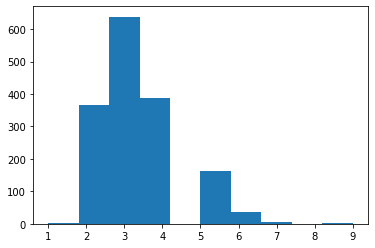

Counter({3: 638, 4: 387, 2: 365, 5: 162, 6: 36, 7: 5, 1: 4, 9: 1})


Gender distribution:


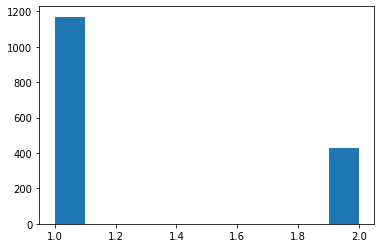

Counter({1: 1170, 2: 428})


In [7]:
from collections import Counter
import matplotlib.pyplot as plt

# Plot histogram of Age and Gender dataset 
print("Age distribution:")
y=np.array(age_target)
plt.hist(y)
plt.show()
count =Counter(list(y))
print(count)
print("\n")

print("Gender distribution:")
y=np.array(gender_target)
plt.hist(y)
plt.show()
count =Counter(list(y))
print(count)



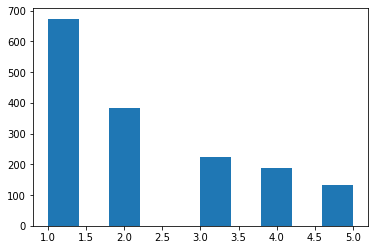

Only 1 element: 0.42125
Only 2 elements: 0.23875
Only 3 elements: 0.139375


Counter({2: 382, 1: 674, 4: 188, 3: 223, 5: 133})

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Plot Kandian items distribution {x-axis = number of elements in each kandian sequence, y-axis = counts }
train, train_target, test = {}, {}, {}
length_list = []
user_index = 0
flat_seq = []
for user in range(len(userid)):
    kandian_seq = kandian_item_seq[user]      
    length_list.append(len(kandian_seq))
   
y=np.array(length_list)
plt.hist(y)
plt.show()

# Top 3 highest counts by percentage 
count = Counter(length_list)
# Only 1 eleemnt in kandian 
print("Only 1 element:",count.most_common()[0][1]/(count.most_common()[0][1]+count.most_common()[1][1]+count.most_common()[2][1]+
 count.most_common()[3][1]+ count.most_common()[4][1]))


print("Only 2 elements:",count.most_common()[1][1]/(count.most_common()[0][1]+count.most_common()[1][1]+count.most_common()[2][1]+
 count.most_common()[3][1]+ count.most_common()[4][1]))


print("Only 3 elements:",count.most_common()[2][1]/(count.most_common()[0][1]+count.most_common()[1][1]+count.most_common()[2][1]+
 count.most_common()[3][1]+ count.most_common()[4][1]))

count

# Create batches

In [9]:
def make_user_sequence(qq_item_seq, maxlen, ft_special_token):
    batch = []
    input_ls, seg_ls, masked_pos = [],[],[]
    
    for i in range(len(qq_item_seq)):
        
        # For 100 sequence length, we take the last 98 tokens from one sequence of training set, 
        # plus 2 special tokens: 1 [CLS], and 2 [SEP] tokens.   
        tokens_a = qq_item_seq[i]
        tokens_a = tokens_a[-(maxlen-2):]
        input_ids = [ft_special_token['[CLS]']] + tokens_a + [ft_special_token['[SEP]']] 

        # Assign 1 to all tokens as segment ids 
        segment_ids = [1] * (1 + len(tokens_a) + 1) 

        
        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)
        
        
        # Append batch data, and input ids, and segment ids
        batch.append([input_ids, segment_ids]) 
        input_ls.append(input_ids)
        seg_ls.append(segment_ids)
        
        
        # Get all token indices other than indices from special tokens
        cand_maked_pos = [i for i, token in enumerate(input_ids) 
                          if token != ft_special_token['[CLS]'] and token != ft_special_token['[SEP]'] and token != ft_special_token['[PAD]'] ]
        
        # Get 2 random masked positions  
        random.shuffle(cand_maked_pos)
        temp_masked_pos = []
        for pos in cand_maked_pos[:2]:
            temp_masked_pos.append(pos)
        masked_pos.append(temp_masked_pos)
           
  
    return batch, input_ls, seg_ls , masked_pos 

In [10]:
len(qq_item_seq)

1598

In [11]:

# Create vocabs dictionary for qq items sequence 
vocab_to_int, int_to_vocab = {}, {}
total_vocab = []
for user in range(len(qq_item_seq)):
    qq_seq = qq_item_seq[user]
    for vocab in qq_seq:
        total_vocab.append(vocab)
    
    
for index, vocab  in enumerate(set(total_vocab)):
    vocab_to_int[vocab] = index+1
    int_to_vocab[index+1] = vocab

In [12]:
len(int_to_vocab)

88284

In [13]:
# Create QQ items sequence using the vocabs dictionary
train, train_target, test = {}, {}, {}
length_list = []
user_index = 0
flat_seq = []
qq_seq_int = []
for user in range(len(qq_item_seq)):
    qq_seq = qq_item_seq[user]
    
    qq_seq_int_temp = []
    for vocab in qq_seq:
        qq_seq_int_temp.append(vocab_to_int[vocab])
    
    length_list.append(len(qq_seq_int))
    
    qq_seq_int.append(qq_seq_int_temp)

In [14]:
maxlen = 100

# Define special tokens
ft_special_token = {'[PAD]': 0, '[CLS]': max(int_to_vocab)+1, '[SEP]': max(int_to_vocab)+2 }

# Create batch, input ids, and masked positions
batch, input_ls, seg_ls, masked_pos = make_user_sequence(qq_seq_int, maxlen, ft_special_token)

# Total vocab size
vocab_size = max(int_to_vocab)+4+15578

In [15]:
print(batch[0])

[[88285, 25869, 5902, 4177, 3395, 17292, 20829, 3199, 7374, 4223, 11347, 24163, 17021, 19199, 82280, 24594, 6425, 62224, 83871, 25536, 26921, 39968, 17714, 5188, 571, 15844, 22959, 25993, 13914, 5998, 48122, 5233, 15629, 4315, 7144, 12119, 2, 57240, 428, 85274, 25530, 44794, 765, 26787, 883, 20852, 39225, 51791, 34576, 64399, 2761, 25531, 31643, 12142, 25565, 21825, 8447, 22750, 7312, 1416, 35167, 8417, 715, 28184, 30534, 37536, 5623, 15012, 34889, 32540, 11870, 12144, 12779, 12089, 24951, 34454, 17389, 6404, 71700, 32893, 35436, 6400, 88286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [16]:
# Obtain length of label set
kandian_labels = [seq[0] for seq in kandian_item_seq]
kandian_label_vocab = len(set(kandian_labels))

gender_label_vocab = len(set(gender_target))

age_label_vocab = len(set(age_target))

In [17]:
set(age_target), set(gender_target)

({1, 2, 3, 4, 5, 6, 7, 9}, {1, 2})

In [18]:
label_to_dict = {}
dict_to_label = {}
kandian_dict_labels = []
age_dict_labels = []
gender_dict_labels = []
age_dict_labels = []

# Create Age target dataset from vocab dictionary
for index, label in enumerate (set(age_target)):
    label_to_dict[label] = index
    dict_to_label[index] = label
    
for label in age_target:
    age_dict_labels.append(label_to_dict[label]) 
    
    
# Create Kandian target dataset from vocab dictionary   
#for index, label in enumerate (set(kandian_labels)):
#    label_to_dict[label] = index
#    dict_to_label[index] = label

#for label in kandian_labels: 
#    kandian_dict_labels.append(label_to_dict[label])  
    


In [19]:
dict_to_label

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 9}

In [20]:
len(label_to_dict)

8

In [21]:
print(input_ls[0])

[88285, 25869, 5902, 4177, 3395, 17292, 20829, 3199, 7374, 4223, 11347, 24163, 17021, 19199, 82280, 24594, 6425, 62224, 83871, 25536, 26921, 39968, 17714, 5188, 571, 15844, 22959, 25993, 13914, 5998, 48122, 5233, 15629, 4315, 7144, 12119, 2, 57240, 428, 85274, 25530, 44794, 765, 26787, 883, 20852, 39225, 51791, 34576, 64399, 2761, 25531, 31643, 12142, 25565, 21825, 8447, 22750, 7312, 1416, 35167, 8417, 715, 28184, 30534, 37536, 5623, 15012, 34889, 32540, 11870, 12144, 12779, 12089, 24951, 34454, 17389, 6404, 71700, 32893, 35436, 6400, 88286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Split train dataset into train, validation and test sets

In [22]:

# Split dataset into training, validation, and testing dataset
def train_test_split(train_split_size, test_split_size, input_ls, seg_ls ):
    # Split between train and evaluation
    split_index = np.round(int(train_split_size*len(input_ls)))
    train_seq,  temp_seq = input_ls[0:split_index], input_ls[split_index:]
    #train_labels, temp_labels = kandian_dict_labels[0:split_index], kandian_dict_labels[split_index:] 
    train_labels, temp_labels = age_dict_labels[0:split_index], age_dict_labels[split_index:]
    train_segment, temp_segment = seg_ls[0:split_index], seg_ls[split_index:]
    train_tok_pos, temp_tok_pos = masked_pos[0:split_index], masked_pos[split_index:]
    
    
    # Split between evaluation and test 
    split_index = np.round(int(test_split_size*len(temp_seq)))
    test_seq, val_seq = temp_seq[0:split_index], temp_seq[split_index:]
    test_labels, val_labels = temp_labels[0:split_index], temp_labels[split_index:] 
    test_segment, val_segment = temp_segment[0:split_index], temp_segment[split_index:] 
    test_tok_pos, val_tok_pos = temp_tok_pos[0:split_index], temp_tok_pos[split_index:]
    
    return train_seq, train_labels, val_seq, val_labels, test_seq, test_labels, train_segment, val_segment, test_segment, train_tok_pos, val_tok_pos, test_tok_pos  
  

In [23]:
tr_seq, tr_labels, v_seq, v_labels, te_seq, te_labels, tr_segment, v_segment, te_segment, tr_tok, v_tok, te_tok= train_test_split(0.7, 0.5, input_ls, seg_ls )


In [24]:
print(tr_seq[10])

[88285, 1187, 4696, 72076, 5569, 4585, 5855, 83724, 83723, 48543, 79246, 1907, 1483, 15871, 1887, 35325, 3570, 4370, 16333, 5379, 31028, 41786, 48528, 242, 86630, 27020, 3569, 268, 9787, 83587, 48538, 86622, 870, 12440, 6572, 83834, 37214, 3947, 83835, 3320, 2835, 7082, 1175, 47683, 41783, 83824, 1422, 41905, 8310, 41904, 5811, 23342, 5745, 71373, 6206, 20988, 4051, 17589, 19917, 2617, 14871, 13307, 83555, 802, 86678, 4643, 26020, 26506, 26507, 783, 9210, 12, 11662, 2496, 2394, 6241, 86751, 4573, 1046, 4167, 3453, 3091, 86734, 4515, 37212, 4735, 4662, 3487, 16648, 7906, 83842, 41889, 6108, 1399, 1663, 312, 8633, 59525, 20036, 88286]


# Import Pre-trained RecoBERT Model

In [25]:
from model import BERT as pre_trained

# Hyperparameters for pre-trained RecoBERT
maxlen = 100 # maximum of length
n_layers = 1 # number of Encoder of Encoder Layer
n_heads = 4 # number of heads in Multi-Head Attention
emb_dim = 128 # Embedding Size
d_ff = 128 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2 # number of segments 

# Load in RecoBERT weight
pre_trained_model = pre_trained(vocab_size, maxlen, emb_dim, n_segments, d_ff, n_layers, d_k, d_v, n_heads)
pre_trained_model.load_state_dict(torch.load("recmodel.bin", map_location=torch.device('cpu')))


<All keys matched successfully>

In [26]:
print(pre_trained_model.classifier.in_features)
print(pre_trained_model.classifier.out_features)

in_features = pre_trained_model.classifier.in_features

# Freeze pre-trained model parameters
for param in pre_trained_model.parameters():
     param.requires_grad = False
        
pre_trained_model

128
2


BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(103866, 128)
    (pos_embed): Embedding(100, 128)
    (seg_embed): Embedding(2, 128)
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=128, out_features=256, bias=True)
        (W_K): Linear(in_features=128, out_features=256, bias=True)
        (W_V): Linear(in_features=128, out_features=256, bias=True)
      )
      (fc1): Linear(in_features=128, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (activ1): Tanh()
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Linear(in_features=128, out_features=103866, bias=Fal

# Convert Integer Sequences to Tensors

In [27]:
# Create tensors for training set
train_seq = torch.tensor(tr_seq)
train_mask = torch.tensor(tr_segment)
train_y = torch.tensor(tr_labels)
train_tok_pos = torch.tensor(tr_tok)


# Create tensors for validation set
val_seq = torch.tensor(v_seq)
val_mask = torch.tensor(v_segment)
val_y = torch.tensor(v_labels)
val_tok_pos = torch.tensor(v_tok)

# Create tensors for testing set
test_seq = torch.tensor(te_seq)
test_mask = torch.tensor(te_segment)
test_y = torch.tensor(te_labels)
test_tok_pos = torch.tensor(te_tok)


In [28]:
len(train_seq), len(train_mask), len(train_y)

(1118, 1118, 1118)

In [29]:
len(v_seq), len(v_segment), len(v_labels)

(240, 240, 240)

In [30]:
len(te_seq), len(te_segment), len(te_labels)

(240, 240, 240)

# Create DataLoaders

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 10

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y, train_tok_pos)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for training set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y, val_tok_pos)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y, test_tok_pos)

# sampler for sampling the data during testing
test_sampler = SequentialSampler(test_data)

# dataLoader for testing set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

# Define Model Architecture

In [32]:
len(label_to_dict)

8

In [33]:
class BERT_Arch(nn.Module):

    def __init__(self, pre_trained_model, cls_dim):
      
        super(BERT_Arch, self).__init__()
        
        pre_trained_model.classifier = nn.Linear(in_features, cls_dim)
        self.bert = pre_trained_model

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # MLP Linear layer 1
        self.mlp_lin = nn.Linear(100,50)
        
        # MLP Linear classifier
        self.mlp_lin2 = nn.Linear(50,age_label_vocab)
        
    
        # Transfer learning: Linear layer 1
        self.mask_lin = nn.Linear(103866,512)
        
        # Transfer learning: Linear classifier 
        self.mask_lin2 = nn.Linear(512,age_label_vocab)
        
    
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, masked_pos, device, n_heads, d_k, d_v, avg_tok=False, mlp=False):
        
        #pass the inputs to the model  
        if mlp == False:
            masked_out , cls_hs1, cls_hs2 = self.bert(sent_id, mask, masked_pos, device, n_heads, d_k, d_v)
        
            x = self.mask_lin(masked_out)
            
            x = self.relu(x)

            x = self.dropout(x)

            # output layer
            x = self.mask_lin2(x)

            # apply softmax activation
            x = self.softmax(x)

                
        else:
            sent_id = torch.tensor(sent_id, dtype=torch.float)
            x = self.mlp_lin(sent_id)
        
            x = self.relu(x)

            x = self.dropout(x)

            # MLP linear classifier output
            x = self.mlp_lin2(x)

            # apply softmax activation
            x = self.softmax(x)

        return x

# Find Class Weights

In [34]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_wts = compute_class_weight(class_weight='balanced', classes= np.unique(kandian_labels), y= kandian_labels)
class_wts = compute_class_weight(class_weight='balanced', classes= np.unique(age_target), y= age_target)

print(class_wts)


[ 49.9375       0.54726027   0.31308777   0.51614987   1.23302469
   5.54861111  39.95       199.75      ]


In [35]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# Define loss function
cross_entropy  = nn.NLLLoss(weight=weights) 



# Fine-Tune RecoBERT

In [36]:
# function to train the model
def train(model, mlp, avg_tok):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels, tok_pos = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask, tok_pos , device, n_heads, 
                  d_k, d_v, avg_tok=avg_tok, mlp=mlp)
    
  
    # compute the loss between actual and predicted values
    if mlp == False:
        preds = torch.mean(preds, dim=1)
    
    
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions, model
  return avg_loss, total_preds, model

In [37]:
# function for evaluating the model
def evaluate(model, mlp, avg_tok):
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels, tok_pos = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask, tok_pos , device, n_heads, 
                    d_k, d_v, avg_tok=avg_tok, mlp=mlp)
    
      
      
      if mlp == False: 
          preds = torch.mean(preds, dim=1)
        
        
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
    

  return avg_loss, total_preds

# Start Model Training

In [38]:

def start(model, mlp, epochs):
# set initial loss to infinite
    best_valid_loss = float('inf')

    # empty lists to store training and validation loss of each epoch
    train_losses=[]
    valid_losses=[]

    #for each epoch
    for epoch in range(epochs):

        if epoch % 20== 0:
            print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        #train model
        train_loss, _, model = train(model, mlp, avg_tok=False )

        #evaluate model
        valid_loss, _ = evaluate(model, mlp, avg_tok=False)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'fine_tuned_weights.pt')

        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # Print losses every 20 epochs
        if epoch % 20== 0:
            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

        
        
    return train_losses, valid_losses, model

In [39]:
# get predictions for test data
def get_accuracy(model, mlp):
    test_preds = []
    with torch.no_grad():

        for step,batch in enumerate(test_dataloader):

            # push the batch to gpu
            batch = [t.to(device) for t in batch]

            sent_id, mask, labels, tok_pos  = batch   
            
            
            preds = model(sent_id, mask, tok_pos , device, n_heads, d_k, d_v, avg_tok=False, mlp=mlp)
 
            if mlp == False:
                preds = torch.mean(preds, dim=1)
            preds = preds.detach().cpu().numpy()
            test_preds.append(preds)

    test_preds_concat =np.concatenate( test_preds, axis=0 )
   
    preds = np.argmax(test_preds_concat, axis = 1)
 
    print("predicted Ages:\n",preds)
    print("True Ages:\n",test_y)
    print("Accuracy score: ",int(accuracy_score(test_y,preds)*100 ),"%")
    
    print(classification_report(test_y, preds))
    

In [40]:
# Free up memory for training
import gc

gc.collect()
torch.cuda.empty_cache()


# Age Classification: Training and Results

In [43]:
# optimizer from hugging face transformers
import time
from transformers import AdamW

# number of training epochs
epochs = 300

########################### Model A ############################
print("Training model A: MLP ")
start_time = time.time()
modelA = BERT_Arch(pre_trained_model,300) # Initialize the fine-tuning model
modelA = modelA.to(device)
# define the optimizer
optimizer = AdamW(modelA.parameters(), lr = 1e-3)
train_losses, valid_losses, modelA = start(modelA, True, epochs)# True here means we want to turn off 
                                                        # transfer learning, and use the simple MLP model
elapsed_time = (time.time() - start_time)
get_accuracy(modelA, True)
print("elapsed time:" ,elapsed_time)
print("-------------------------------------------")

########################### Model B ############################
print("Training model B: Freeze + Fine-tune ")
start_time = time.time()
# pass the pre-trained RecoBERT to our define architecture
modelB = BERT_Arch(pre_trained_model,300)
modelB = modelB.to(device)
# define the optimizer
optimizer = AdamW(modelB.parameters(), lr = 1e-3)
train_losses2, valid_losses2, modelB = start(modelB,False, epochs) 
elapsed_time = (time.time() - start_time)
get_accuracy(modelB, False)
print("elapsed time:" ,elapsed_time)
print("-------------------------------------------")


############################# Model C ############################
print("Training model C: Fine-tune all ")
start_time = time.time()
# Unfreeze pre-trained weights
for param in pre_trained_model.parameters():
     param.requires_grad = True
modelC = BERT_Arch(pre_trained_model,300)
modelC = modelC.to(device)
# define the optimizer
optimizer = AdamW(modelC.parameters(), lr = 1e-3)
train_losses3, valid_losses3, modelC = start(modelC,False, epochs)
elapsed_time = (time.time() - start_time)
get_accuracy(modelC, False)
print("elapsed time:" ,elapsed_time)
print("-------------------------------------------")



Training model A: MLP 


/mistgpu/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_474/3723802966.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_id = torch.tensor(sent_id, dtype=torch.float)



 Epoch 1 / 300

Training Loss: 3127.034
Validation Loss: 957.751

 Epoch 21 / 300

Training Loss: 1.734
Validation Loss: 6.484

 Epoch 41 / 300

Training Loss: 1.706
Validation Loss: 5.553

 Epoch 61 / 300

Training Loss: 1.698
Validation Loss: 5.547

 Epoch 81 / 300

Training Loss: 1.720
Validation Loss: 5.546

 Epoch 101 / 300

Training Loss: 1.696
Validation Loss: 5.546

 Epoch 121 / 300

Training Loss: 1.702
Validation Loss: 5.486

 Epoch 141 / 300

Training Loss: 1.694
Validation Loss: 5.494

 Epoch 161 / 300

Training Loss: 1.707
Validation Loss: 5.424

 Epoch 181 / 300

Training Loss: 1.713
Validation Loss: 5.422

 Epoch 201 / 300

Training Loss: 1.717
Validation Loss: 5.419

 Epoch 221 / 300

Training Loss: 1.710
Validation Loss: 5.419

 Epoch 241 / 300

Training Loss: 1.723
Validation Loss: 5.419

 Epoch 261 / 300

Training Loss: 1.706
Validation Loss: 5.420

 Epoch 281 / 300

Training Loss: 1.723
Validation Loss: 5.421
predicted Ages:
 [2 2 2 2 1 2 2 5 2 2 2 2 2 2 2 2 2 2 2 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1


 Epoch 1 / 300

Training Loss: 0.699
Validation Loss: 0.693

 Epoch 21 / 300

Training Loss: 0.927
Validation Loss: 0.693

 Epoch 41 / 300

Training Loss: 0.960
Validation Loss: 0.693

 Epoch 61 / 300

Training Loss: 1.046
Validation Loss: 0.694

 Epoch 81 / 300

Training Loss: 1.052
Validation Loss: 0.693

 Epoch 101 / 300

Training Loss: 1.032
Validation Loss: 0.693

 Epoch 121 / 300

Training Loss: 0.999
Validation Loss: 0.694

 Epoch 141 / 300

Training Loss: 1.269
Validation Loss: 0.693

 Epoch 161 / 300

Training Loss: 1.126
Validation Loss: 0.693

 Epoch 181 / 300

Training Loss: 1.168
Validation Loss: 0.693

 Epoch 201 / 300

Training Loss: 1.179
Validation Loss: 0.693

 Epoch 221 / 300

Training Loss: 1.083
Validation Loss: 0.693

 Epoch 241 / 300

Training Loss: 1.110
Validation Loss: 0.693

 Epoch 261 / 300

Training Loss: 1.086
Validation Loss: 0.693

 Epoch 281 / 300

Training Loss: 1.118
Validation Loss: 0.693
predicted Ages:
 [2 3 1 3 2 2 2 2 2 7 6 2 1 2 1 4 0 4 1 2 4 3

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mistgpu/site-packages/transformers/optimization.py:306: FutureWarning: This implementation


 Epoch 1 / 300

Training Loss: 0.701
Validation Loss: 0.693

 Epoch 21 / 300

Training Loss: 0.869
Validation Loss: 0.693

 Epoch 41 / 300

Training Loss: 0.901
Validation Loss: 0.693

 Epoch 61 / 300

Training Loss: 0.950
Validation Loss: 0.693

 Epoch 81 / 300

Training Loss: 0.964
Validation Loss: 0.693

 Epoch 101 / 300

Training Loss: 0.945
Validation Loss: 0.693

 Epoch 121 / 300

Training Loss: 0.977
Validation Loss: 0.693

 Epoch 141 / 300

Training Loss: 1.024
Validation Loss: 0.693

 Epoch 161 / 300

Training Loss: 0.963
Validation Loss: 0.693

 Epoch 181 / 300

Training Loss: 0.972
Validation Loss: 0.693

 Epoch 201 / 300

Training Loss: 1.090
Validation Loss: 0.693

 Epoch 221 / 300

Training Loss: 0.974
Validation Loss: 0.693

 Epoch 241 / 300

Training Loss: 1.095
Validation Loss: 0.693

 Epoch 261 / 300

Training Loss: 1.046
Validation Loss: 0.693

 Epoch 281 / 300

Training Loss: 1.082
Validation Loss: 0.693
predicted Ages:
 [3 2 5 5 2 3 2 7 1 1 2 4 3 0 2 2 3 3 2 3 1 1

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


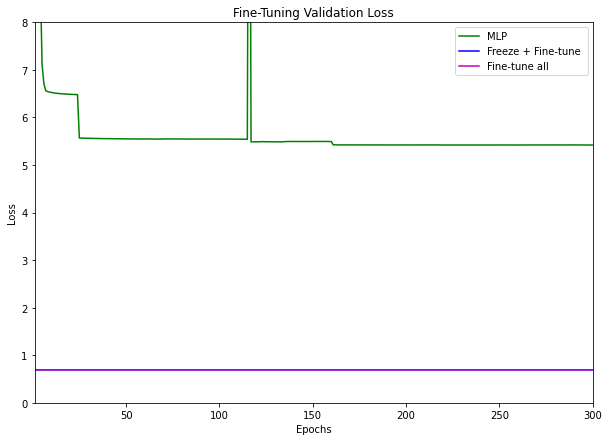

In [50]:
epochs_plot = range(1, epochs+1)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
axes.plot(epochs_plot, valid_losses, 'g', label='MLP')
axes.plot(epochs_plot, valid_losses2, 'b', label='Freeze + Fine-tune ')
axes.plot(epochs_plot, valid_losses3, 'm', label='Fine-tune all')
axes.set(ylabel='Loss')
axes.set(xlabel='Epochs')
axes.legend(loc='upper right')
axes.set_title('Fine-Tuning Validation Loss')
plt.axis([1, 300, 0, 8])
plt.savefig('Agenewloss1.jpg')